# Accion del Campo:
$S = \int dx⁴ \frac{1}{2}\sqrt{-g}(g^{\mu\nu}\partial_\mu \phi∂_\nu\phi - m²\phi²)$

In [ ]:
# Librerias
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import time
import numpy as np
import numba as nb

@nb.njit
def contorno(i, n):
    """Condiciones de contorno periódicas."""
    return (i + n) % n

@nb.njit
def fuerza_vecinos(phi, t, x, y, Nt, Nx, Ny, g_inv, g_det):
    """
    Calcula la interacción con vecinos ponderada por la métrica.
    g_inv tiene forma (Nt, Nx, Ny, 3) donde 0:tt, 1:xx, 2:yy
    """
    tm, tp = contorno(t-1, Nt), contorno(t+1, Nt)
    xm, xp = contorno(x-1, Nx), contorno(x+1, Nx)
    ym, yp = contorno(y-1, Ny), contorno(y+1, Ny)

    # Pesos geométricos locales
    wt = g_det[t,x,y] * g_inv[t,x,y,0]
    wx = g_det[t,x,y] * g_inv[t,x,y,1]
    wy = g_det[t,x,y] * g_inv[t,x,y,2]

    # Suma ponderada de vecinos (Fuerza)
    fuerza = (wt * (phi[tp,x,y] + phi[tm,x,y]) +
              wx * (phi[t,xp,y] + phi[t,xm,y]) +
              wy * (phi[t,x,yp] + phi[t,x,ym]))

    # Masa geométrica (costo cinético local)
    m_geom = 2 * (wt + wx + wy)
    return fuerza, m_geom

@nb.njit
def calc_delta_S(phi_val, d, fuerza, m_geom, m2, lam, g_sqrt):
    """Calcula el cambio exacto en la acción para un cambio 'd'."""
    phi_new = phi_val + d
    phi2_old = phi_val**2
    phi2_new = phi_new**2

    # Acción Local Potencial
    S_pot_old = g_sqrt * (0.5 * m2 * phi2_old + lam * phi2_old**2)
    S_pot_new = g_sqrt * (0.5 * m2 * phi2_new + lam * phi2_new**2)

    # Acción Cinética Local
    S_kin_old = 0.5 * m_geom * phi2_old - fuerza * phi_val
    S_kin_new = 0.5 * m_geom * phi2_new - fuerza * phi_new

    return (S_pot_new + S_kin_new) - (S_pot_old + S_kin_old)

@nb.njit
def metropolis_sweep_curvo(phi, lam, m2, delta, Nt, Nx, Ny, g_inv, g_det):
    """Barrido Metropolis estándar."""
    aceptados = 0
    N = Nt * Nx * Ny
    indices = np.arange(N)
    np.random.shuffle(indices) # Aleatoriedad para balance detallado

    for idx in indices:
        t = idx // (Nx * Ny)
        x = (idx // Ny) % Nx
        y = idx % Ny

        # 1. Calcular entorno
        fuerza, m_geom = fuerza_vecinos(phi, t, x, y, Nt, Nx, Ny, g_inv, g_det)

        # 2. Proponer cambio
        d = np.random.uniform(-delta, delta)

        # 3. Calcular Delta S
        dS = calc_delta_S(phi[t,x,y], d, fuerza, m_geom, m2, lam, g_det[t,x,y])

        # 4. Aceptar/Rechazar
        if dS < 0 or np.random.rand() < np.exp(-dS):
            phi[t,x,y] += d
            aceptados += 1

    return phi, aceptados / N

@nb.njit
def microcanonical_sweep_curvo(phi, lam, m2, Nt, Nx, Ny, g_inv, g_det):
    """Barrido de Overrelaxation (Microcanónico aproximado)."""
    aceptados = 0
    N = Nt * Nx * Ny

    for idx in range(N): # Secuencial es OK para overrelaxation
        t = idx // (Nx * Ny)
        x = (idx // Ny) % Nx
        y = idx % Ny

        phi_old = phi[t,x,y]
        fuerza, m_geom = fuerza_vecinos(phi, t, x, y, Nt, Nx, Ny, g_inv, g_det)

        # Proponer reflexión respecto al mínimo local cuadrático
        denom = m_geom + m2 * g_det[t,x,y]
        if denom == 0: continue # Evitar div por cero

        phi_center = fuerza / denom
        phi_new = 2 * phi_center - phi_old

        d = phi_new - phi_old
        dS = calc_delta_S(phi_old, d, fuerza, m_geom, m2, lam, g_det[t,x,y])

        # Paso de aceptación (Metropolis)
        if dS < 0 or np.random.rand() < np.exp(-dS):
            phi[t,x,y] = phi_new
            aceptados += 1

    return phi, aceptados / N

@nb.njit
def autocorrelation_func(config, t_max):
    """Calcula la función de autocorrelación."""
    z = config.shape[0]
    phi_mean = np.mean(config)
    phi_var = np.var(config)

    if phi_var == 0:
        return np.zeros(t_max)

    autocorr = np.zeros(t_max)
    for i in range(t_max):
        data_t = config[:z-i]
        data_t_plus_k = config[i:]
        cov = np.mean((data_t - phi_mean) * (data_t_plus_k - phi_mean))
        autocorr[i] = cov / phi_var

    return autocorr

In [ ]:
class LatticeSimulation:
    def __init__(self, Nt, Nx, Ny, lam, m2, g_inv, g_det, delta):
        """
        Inicializa la simulación en espacio curvo.
        """
        print("Inicializando simulación en Espacio Curvo...")
        self.Nt, self.Nx, self.Ny = Nt, Nx, Ny
        self.lam = lam
        self.m2 = m2
        self.delta = delta

        # Asegurar tipos correctos para Numba
        self.g_inv = g_inv.astype(np.float64)
        self.g_det = g_det.astype(np.float64)

        # Inicializar red (Hot start)
        self.phi = np.random.normal(scale=0.5, size=(Nt, Nx, Ny))
        print(f"  Red creada: {self.phi.shape}")

        self.historia_magnetizacion = []
        self.historia_aceptacion = []

    def run_simulation(self, sweeps_termalizacion, sweeps_medicion, freq_micro=3):
        """
        Ejecuta la simulación: Termalización + Medición.
        Usa barridos híbridos: 1 Metropolis + freq_micro Microcanónicos.
        """
        print(f"\n--- Iniciando Simulación ---")
        print(f"Termalización: {sweeps_termalizacion} sweeps")
        print(f"Medición: {sweeps_medicion} sweeps (Híbridos 1+{freq_micro})")

        start_time = time.time()

        # --- FASE 1: Termalización ---
        print("Termalizando...")
        for i in range(sweeps_termalizacion):
            self.phi, _ = metropolis_sweep_curvo(
                self.phi, self.lam, self.m2, self.delta,
                self.Nt, self.Nx, self.Ny, self.g_inv, self.g_det
            )

        # --- FASE 2: Medición ---
        print("Midiendo...")
        for i in range(sweeps_medicion):
            # 1. Paso Ergodicidad (Metropolis)
            self.phi, acc_met = metropolis_sweep_curvo(
                self.phi, self.lam, self.m2, self.delta,
                self.Nt, self.Nx, self.Ny, self.g_inv, self.g_det
            )

            # 2. Pasos Descorrelación (Microcanónico)
            for _ in range(freq_micro):
                self.phi, _ = microcanonical_sweep_curvo(
                    self.phi, self.lam, self.m2,
                    self.Nt, self.Nx, self.Ny, self.g_inv, self.g_det
                )

            # Guardar observables
            mag = np.mean(self.phi)
            self.historia_magnetizacion.append(mag)
            self.historia_aceptacion.append(acc_met)

            if (i+1) % (sweeps_medicion // 10) == 0:
                print(f"  Progreso: {i+1}/{sweeps_medicion} | <phi>: {mag:.4f} | Acc: {acc_met:.2f}")

        print(f"Simulación finalizada en {time.time() - start_time:.2f}s")

    def analyze_autocorrelation(self, max_lag_percent=0.1, plot=True):
        """Analiza la autocorrelación de la magnetización."""
        data = np.array(self.historia_magnetizacion)
        if len(data) < 100:
            print("Datos insuficientes para autocorrelación.")
            return

        t_max = int(len(data) * max_lag_percent)
        lags = np.arange(t_max)
        autocorr = autocorrelation_func(data, t_max)

        # Buscar tiempo integrado (tau) donde A(tau) < 0.1
        tau = np.nan
        indices = np.where(autocorr < 0.1)[0]
        if len(indices) > 0:
            tau = indices[0]
            print(f"Tiempo de autocorrelación estimado (tau): {tau} sweeps")
        else:
            print("Advertencia: La autocorrelación no decae a 0.1 en el rango analizado.")

        if plot:
            plt.figure(figsize=(10, 5))
            plt.plot(lags, autocorr, marker='o', markevery=20, linestyle='-', label='Autocorrelacion')
            plt.axhline(0.1, color='r', linestyle='--', label='Umbral 0.1')
            plt.axhline(0, color='k', linewidth=0.5)
            plt.xlabel('Lag (Sweeps)')
            plt.ylabel('A(t)')
            plt.title(f'Autocorrelación (tau ~ {tau})')
            plt.legend()
            plt.grid()
            plt.show()

        return

# Comprobamos resultados para Minkowski

Inicializando simulación en Espacio Curvo...
  Red creada: (16, 8, 8)

--- Iniciando Simulación ---
Termalización: 500 sweeps
Medición: 6000 sweeps (Híbridos 1+0)
Termalizando...
Midiendo...
  Progreso: 600/6000 | <phi>: -0.0016 | Acc: 0.42
  Progreso: 1200/6000 | <phi>: -0.0094 | Acc: 0.41
  Progreso: 1800/6000 | <phi>: -0.0371 | Acc: 0.37
  Progreso: 2400/6000 | <phi>: -0.0313 | Acc: 0.42
  Progreso: 3000/6000 | <phi>: -0.0503 | Acc: 0.41
  Progreso: 3600/6000 | <phi>: -0.0748 | Acc: 0.40
  Progreso: 4200/6000 | <phi>: -0.0093 | Acc: 0.43
  Progreso: 4800/6000 | <phi>: 0.0111 | Acc: 0.40
  Progreso: 5400/6000 | <phi>: 0.0292 | Acc: 0.40
  Progreso: 6000/6000 | <phi>: -0.0847 | Acc: 0.44
Simulación finalizada en 1.00s
Tiempo de autocorrelación estimado (tau): 106 sweeps


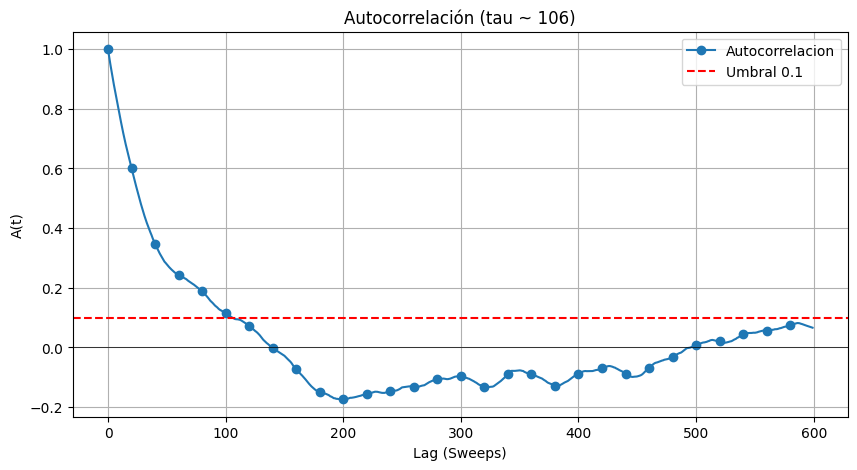

In [ ]:
# Parámetros de prueba
Nt, Nx, Ny = 16, 8, 8
lam = 0.1
m2 = 0.1
delta = 1.5

# Definir métrica (Espacio Plano Euclídeo para verificar)
# g_inv diagonal: [1, 1, 1]
g_inv = np.zeros((Nt, Nx, Ny, 3))
g_inv[..., :] = 1.0

# g_det = 1
g_det = np.ones((Nt, Nx, Ny))

# Instanciar y correr
sim = LatticeSimulation(Nt, Nx, Ny, lam, m2, g_inv, g_det, delta)
mag = sim.run_simulation(sweeps_termalizacion=500, sweeps_medicion=6000, freq_micro=0)

# Analizar
sim.analyze_autocorrelation()

# Consideramos $\eta^{\mu\nu} +\epsilon cos(wt)$ (Minkoswki + una pequeña variacion)